In [1]:
from pandas_datareader import data as pdr
from yahoo_fin import stock_info as si
import yfinance as yf
import pandas as pd
import datetime
import time
import talib
from talib import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost as xgb
import math
import numpy as np
from sklearn.decomposition import PCA
import pickle
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'
yf.pdr_override()

In [2]:
from LSSVMRegression import LSSVMRegression

In [3]:
def add_indicators():
        
    R_S_I = RSI(df['Adj Close'], timeperiod=slow)
    E_M_A = EMA(df['Adj Close'], timeperiod=fast)
    macd, macdsig, macdhist = MACD(df['Adj Close'], fastperiod=fast, slowperiod=slow, signalperiod=really_fast)
    mfi = MFI(df['High'], df['Low'], df['Adj Close'],df['Volume'],timeperiod=fast)
    slowk, slowd = STOCH(df['High'], df['Low'], df['Adj Close'], fastk_period=fast, slowk_period=slow, slowk_matype=0, slowd_period=slow, slowd_matype=0)
    
    #
    #
    #
    
    df['ema'] = E_M_A
    df['rsi'] = R_S_I
    df['macd'] = macd
    df['macdsig'] = macdsig
    df['macdhist'] = macdhist
    df['mfi'] = mfi
    df['slowK'] = slowk
    df['slowD'] = slowd
    
    
    
    ####
    
    

    #76 vars

    #are_all_zero = (test_TA == 0).all()
    #true if all values are 0
    #false if contain a non 0'''

    df.drop(['Close'], axis =1, inplace = True)

    

In [4]:
def add_lag(num_lag_cols, this_df):
    
    tic = time.perf_counter()
    
    '''df['ema'] = E_M_A
    df['rsi'] = R_S_I
    df['macd'] = macd
    df['macdsig'] = macdsig
    df['macdhist'] = macdhist
    df['mfi'] = mfi
    df['slowK'] = slowk
    df['slowD'] = slowd'''
    
    lag_cols = ['open',
                 'high',
                 'low',
                 'adj_close',
                 'volume',
                 'ema',
                 'rsi',
                 'macd',
                 'macdsig',
                 'macdhist',
                 'mfi',
                 'slowk',
                 'slowd']

    shift_range = [x+1 for x in range(num_lag_cols)]

    for shift in shift_range:
        train_shift = this_df[merging_keys + lag_cols].copy()

        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift

        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        this_df = pd.merge(this_df, train_shift, on=merging_keys, how='left') #.fillna(0)

    del train_shift
    
    toc = time.perf_counter()

    tic_toc = (toc - tic) / 60

    print(f"completed lagging in {tic_toc:0.4f} min")
    

    return this_df

In [25]:
def add_scale(num_interval_lag):

    cols_to_scale = ['open',#
                     'high',#
                     'low',#
                     'adj_close',#
                     'volume',#
                     'ema',#
                     'rsi',#
                     'macd',#
                     'macdsig',#
                     'macdhist',#
                     'mfi',#
                     'slowk',#
                     'slowd']#
                    

    for i in range(1,num_interval_lag+1):
        cols_to_scale.append("ema_lag_"+str(i))
        cols_to_scale.append("slowk_lag_"+str(i))
        cols_to_scale.append("slowd_lag_"+str(i))
        cols_to_scale.append("rsi_lag_"+str(i))

        cols_to_scale.append("volume_lag_"+str(i))

        cols_to_scale.append("adj_close_lag_"+str(i))
        
        cols_to_scale.append("open_lag_"+str(i))
        cols_to_scale.append("high_lag_"+str(i))
        cols_to_scale.append("low_lag_"+str(i))

        cols_to_scale.append("macd_lag_"+str(i))
        cols_to_scale.append("macdsig_lag_"+str(i))
        cols_to_scale.append("macdhist_lag_"+str(i))

        cols_to_scale.append("mfi_lag_"+str(i))
      
    return cols_to_scale

In [26]:
stock = 'MSFT'

start_date = datetime.datetime.now() - datetime.timedelta(days=59)

end_date = datetime.datetime.now()

df = pdr.get_data_yahoo(stock, start=start_date, end=end_date, interval = "2m", prepost = True)

#df = pdr.get_data_yahoo(stock, period = "max", interval = "1d", prepost = True)

#df.index = df.index.tz_localize(None)

'''#2 min ticker
# 30 intervals = 1 hour << OLD
# 195 intervals = trading day'''
                                            # there are more intervals that we can use / change
really_fast = 30
fast = 60
slow = 90

add_indicators()

# Convert Date column to datetime
df.reset_index(level=0, inplace=True)

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

df['order_day'] = [x for x in list(range(len(df)))]
# merging_keys


# Get difference between high and low of each day

[*********************100%***********************]  1 of 1 completed


In [27]:
col_list = df.columns.to_list()
col_list.remove('datetime')

In [28]:
col_list

['open',
 'high',
 'low',
 'adj_close',
 'volume',
 'ema',
 'rsi',
 'macd',
 'macdsig',
 'macdhist',
 'mfi',
 'slowk',
 'slowd',
 'order_day']

In [29]:
merging_keys = ['order_day']

num_interval_lag = 30

df = add_lag(num_interval_lag, df)

#df['adj_close'] = df['adj_close'].shift(30)

completed lagging in 0.0314 min


In [30]:
print(df.shape)

(15126, 405)


In [31]:
print(df.head(40))

                    datetime    open    high     low  adj_close  volume  ema  \
0  2021-01-13 19:02:00-05:00  216.56  216.60  216.50     216.60       0  NaN   
1  2021-01-13 19:04:00-05:00  216.55  216.60  216.50     216.50       0  NaN   
2  2021-01-13 19:08:00-05:00  216.50  216.65  216.50     216.65       0  NaN   
3  2021-01-13 19:10:00-05:00  216.52  216.52  216.52     216.52       0  NaN   
4  2021-01-13 19:12:00-05:00  216.79  216.79  216.56     216.64       0  NaN   
5  2021-01-13 19:16:00-05:00  216.55  216.79  216.52     216.79       0  NaN   
6  2021-01-13 19:18:00-05:00  216.79  216.79  216.52     216.79       0  NaN   
7  2021-01-13 19:20:00-05:00  216.76  216.79  216.52     216.52       0  NaN   
8  2021-01-13 19:22:00-05:00  216.79  216.79  216.64     216.64       0  NaN   
9  2021-01-13 19:24:00-05:00  216.78  216.79  216.62     216.79       0  NaN   
10 2021-01-13 19:26:00-05:00  216.79  216.79  216.54     216.79       0  NaN   
11 2021-01-13 19:28:00-05:00  216.79  21

In [32]:
window_size = 30

df['adj_close'] = df['adj_close'].shift(-window_size)



In [33]:
cols_to_rem = ['open',
                 'high',
                 'low',
                 'volume',
                 'ema',
                 'rsi',
                 'macd',
                 'macdsig',
                 'macdhist',
                 'mfi',
                 'slowk',
                 'slowd',
                 'order_day']

In [34]:
close_vals_list = df['adj_close']

In [35]:
df.drop(cols_to_rem, axis = 1, inplace = True)

In [36]:
print(df.tail(40))

                       datetime   adj_close  open_lag_1  high_lag_1  \
15086 2021-03-04 08:32:00-05:00  227.820007  227.700000  227.980000   
15087 2021-03-04 08:34:00-05:00  228.320007  227.500000  227.860000   
15088 2021-03-04 08:36:00-05:00  228.720001  227.500000  227.700000   
15089 2021-03-04 08:38:00-05:00  228.889999  227.500000  227.860000   
15090 2021-03-04 08:40:00-05:00  228.889999  227.340000  227.850000   
15091 2021-03-04 08:42:00-05:00  228.149994  227.400000  227.800000   
15092 2021-03-04 08:44:00-05:00  228.139999  227.800000  227.850000   
15093 2021-03-04 08:46:00-05:00  227.679993  227.600000  227.800000   
15094 2021-03-04 08:48:00-05:00  227.399994  227.600000  227.680000   
15095 2021-03-04 08:50:00-05:00  227.570007  227.499900  227.500000   
15096 2021-03-04 08:52:00-05:00         NaN  227.450000  227.490000   
15097 2021-03-04 08:54:00-05:00         NaN  227.400000  227.500000   
15098 2021-03-04 08:56:00-05:00         NaN  227.200000  227.400000   
15099 

In [37]:


#close_vals_list = df['adj_close']

df.fillna(0, inplace=True)

#df.fillna(0, inplace=True)

#BUY => 1, SELL => 0, HOLD => 2

num_test = int(.10*len(df))
num_train = len(df) - num_test

# Split into train, cv, and test
train = df[:num_train]
test = df[num_train:]

#print(test['datetime'].iloc[[-1]])
#print(test['test_labels'].iloc[[-1]])

train_close_vals = close_vals_list[:num_train]
test_close_vals = close_vals_list[num_train:]

#test_dates_list = test['date']
#BUY => 1, SELL => 0, HOLD => 2

In [38]:
test_dates_list = test['datetime']

In [39]:
train_dates_list = train['datetime']

In [40]:
test_adj_close_list = close_vals_list[num_train:]

In [41]:
cols_to_scale = add_scale(num_interval_lag)
#cols_to_scale.remove(cols_to_rem)

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak


In [42]:
for element in cols_to_rem:

    if element in cols_to_scale:

        cols_to_scale.remove(element)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

In [44]:
#scaler = StandardScaler()

scaler = MinMaxScaler()

scaler.fit(train[cols_to_scale])
train_scaled = scaler.transform(train[cols_to_scale])

# Convert the numpy array back into pandas dataframe

train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)

train_scaled = train_scaled[slow:]
train = train[slow:]

#scaling test dataset

#scaler_2 = StandardScaler()

#scaler_2  = MinMaxScaler(feature_range=(-1,1))
#scaler.fit(test[cols_to_scale])
test_scaled = scaler.transform(test[cols_to_scale])

# Convert the numpy array back into pandas dataframe

test_scaled = pd.DataFrame(test_scaled, columns=cols_to_scale)

features = cols_to_scale

In [45]:
features

['adj_close',
 'ema_lag_1',
 'slowk_lag_1',
 'slowd_lag_1',
 'rsi_lag_1',
 'volume_lag_1',
 'adj_close_lag_1',
 'open_lag_1',
 'high_lag_1',
 'low_lag_1',
 'macd_lag_1',
 'macdsig_lag_1',
 'macdhist_lag_1',
 'mfi_lag_1',
 'ema_lag_2',
 'slowk_lag_2',
 'slowd_lag_2',
 'rsi_lag_2',
 'volume_lag_2',
 'adj_close_lag_2',
 'open_lag_2',
 'high_lag_2',
 'low_lag_2',
 'macd_lag_2',
 'macdsig_lag_2',
 'macdhist_lag_2',
 'mfi_lag_2',
 'ema_lag_3',
 'slowk_lag_3',
 'slowd_lag_3',
 'rsi_lag_3',
 'volume_lag_3',
 'adj_close_lag_3',
 'open_lag_3',
 'high_lag_3',
 'low_lag_3',
 'macd_lag_3',
 'macdsig_lag_3',
 'macdhist_lag_3',
 'mfi_lag_3',
 'ema_lag_4',
 'slowk_lag_4',
 'slowd_lag_4',
 'rsi_lag_4',
 'volume_lag_4',
 'adj_close_lag_4',
 'open_lag_4',
 'high_lag_4',
 'low_lag_4',
 'macd_lag_4',
 'macdsig_lag_4',
 'macdhist_lag_4',
 'mfi_lag_4',
 'ema_lag_5',
 'slowk_lag_5',
 'slowd_lag_5',
 'rsi_lag_5',
 'volume_lag_5',
 'adj_close_lag_5',
 'open_lag_5',
 'high_lag_5',
 'low_lag_5',
 'macd_lag_5',
 '

In [46]:
features.remove('adj_close')

In [47]:
print('adj_close' in features)

False


In [48]:
print('adj_close' in train_scaled.columns)

True


In [49]:
#features.remove(target)

# Split into X and y
'''X_train_scaled = train_scaled[features]
y_train_scaled = train['labels']

X_test_scaled = test_scaled[features]
y_test_scaled = test['labels']'''

X_train = train_scaled[features]
y_train = train_scaled['adj_close']

X_test = test_scaled[features]
y_test = train_scaled['adj_close']

In [50]:
X_test

,ema_lag_1,slowk_lag_1,slowd_lag_1,rsi_lag_1,volume_lag_1,adj_close_lag_1,open_lag_1,high_lag_1,low_lag_1,macd_lag_1,...,rsi_lag_30,volume_lag_30,adj_close_lag_30,open_lag_30,high_lag_30,low_lag_30,macd_lag_30,macdsig_lag_30,macdhist_lag_30,mfi_lag_30
0,0.954924,0.877631,0.733483,0.772593,0.000000,0.955199,0.954696,0.938278,0.955199,0.566891,...,0.793838,0.0,0.954956,0.954939,0.938557,0.954956,0.370658,0.304569,0.420563,3.673967e-15
1,0.955105,0.877481,0.738116,0.779075,0.000000,0.955888,0.954777,0.938955,0.955280,0.569075,...,0.790946,0.0,0.954713,0.954453,0.938040,0.954713,0.385090,0.310170,0.442448,3.673967e-15
2,0.955250,0.876568,0.742698,0.767643,0.000000,0.954997,0.955304,0.938955,0.954997,0.569861,...,0.791284,0.0,0.954754,0.954251,0.937841,0.953579,0.398769,0.316424,0.461308,3.673967e-15
3,0.955421,0.876481,0.747241,0.776043,0.000000,0.955888,0.954534,0.939034,0.954997,0.571570,...,0.791967,0.0,0.954835,0.953077,0.937920,0.953538,0.411777,0.323237,0.477511,3.673967e-15
4,0.955591,0.876288,0.751756,0.777561,0.000000,0.956050,0.955425,0.939114,0.955928,0.573232,...,0.792656,0.0,0.954916,0.954170,0.938358,0.954672,0.424141,0.330526,0.491288,3.673967e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,0.925292,0.700299,0.575934,0.746181,0.033649,0.927168,0.926599,0.911918,0.926763,0.403863,...,0.695486,0.0,0.921943,0.922267,0.906606,0.921416,0.394360,0.382092,0.320131,3.673967e-15
1508,0.925399,0.702494,0.580292,0.711794,0.033330,0.924171,0.926599,0.911102,0.923685,0.406826,...,0.699182,0.0,0.922267,0.921457,0.906407,0.921943,0.396124,0.383509,0.321344,3.673967e-15
1509,0.925502,0.704650,0.584628,0.711346,0.022062,0.924130,0.923725,0.909272,0.923847,0.409537,...,0.690207,0.0,0.921538,0.921457,0.905929,0.920241,0.396841,0.384888,0.320236,3.673967e-15
1510,0.925540,0.704915,0.588921,0.691113,0.026913,0.922267,0.923644,0.907998,0.921983,0.409711,...,0.682334,0.0,0.920890,0.921052,0.905213,0.919917,0.396670,0.386165,0.317295,3.673967e-15


In [51]:
y_train

90       0.358195
91       0.358400
92       0.359425
93       0.357171
94       0.362089
           ...   
13609    0.760655
13610    0.771106
13611    0.756352
13612    0.767008
13613    0.762909
Name: adj_close, Length: 13524, dtype: float64

In [179]:
import pyswarms as ps

from sklearn.metrics import mean_squared_error

In [180]:
def fitness_function(position):
    
    #print(position)
    
    #svrRegressor = SVR(kernel='rbf', gamma = position[0].all(), C = position[1].all() )
    
    clfrbf=LSSVMRegression(
        gamma=position[0].all(),       #set the gamma-hyper parameter equal to 1
        kernel='rbf', #use the linear kernel
        sigma=position[1].all(),
            )
    
    clfrbf.fit(X_train, y_train)
    
    y_train_pred = clfrbf.predict(X_train)
    
    y_test_pred = clfrbf.predict(X_test)
    
    mse_test =mean_squared_error(y_test, y_test_pred)
    
    rmse_test = math.sqrt(mse_test)
    
    print('Optimizing the Parameters ..... C = {c}, Gamma={gamma}'.format(c=position[1], gamma=position[0]))
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    
    rmse_train = math.sqrt(mse_train)
    
    #list(range(mse_f_train,rmse_f_train))
    retVal= rmse_test #Return a vector instead of single value. you can use the rmse_test and ignore rmse_train
    
    return retVal

In [42]:
lb = [10, 0.0001]
ub = [1000,0.1]
#mb = [100, 0.001]
bounds = (lb,ub)

options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=2,options=options, bounds = bounds)
gamma_opt, C_opt = optimizer.optimize(fitness_function, iters=50)

2021-03-03 08:39:08,998 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   2%|█▏                                                           |1/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.33571874e+02 3.58935260e-02], Gamma=[5.51052404e+02 6.37079574e-02]


pyswarms.single.global_best:   4%|██▍                                                          |2/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.37524244e+02 4.37617249e-02], Gamma=[5.51848210e+02 9.90664312e-02]


pyswarms.single.global_best:   6%|███▋                                                         |3/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.40616042e+02 8.44931591e-02], Gamma=[5.52181305e+02 4.20711615e-02]


pyswarms.single.global_best:   8%|████▉                                                        |4/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.40651613e+02 5.12145173e-02], Gamma=[5.52029811e+02 2.94719709e-02]


pyswarms.single.global_best:  10%|██████                                                       |5/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.39467280e+02 5.76052241e-02], Gamma=[5.51276216e+02 6.11282725e-02]


pyswarms.single.global_best:  12%|███████▎                                                     |6/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.37257362e+02 4.97255351e-03], Gamma=[5.50500575e+02 4.13633329e-02]


pyswarms.single.global_best:  14%|████████▌                                                    |7/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.36923580e+02 2.92975039e-02], Gamma=[5.49939453e+02 8.52918121e-02]


pyswarms.single.global_best:  16%|█████████▊                                                   |8/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.38696712e+02 1.80167128e-02], Gamma=[5.49687645e+02 7.68937383e-02]


pyswarms.single.global_best:  18%|██████████▉                                                  |9/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.40496391e+02 7.01459697e-02], Gamma=[5.50255968e+02 2.41137212e-02]


pyswarms.single.global_best:  20%|████████████                                                |10/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.43953200e+02 8.51044814e-02], Gamma=[5.51138501e+02 4.59140096e-02]


pyswarms.single.global_best:  22%|█████████████▏                                              |11/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.43147502e+02 4.81223971e-02], Gamma=[5.51901072e+02 4.45005565e-02]


pyswarms.single.global_best:  24%|██████████████▍                                             |12/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.43516162e+02 8.40926696e-02], Gamma=[5.52385078e+02 2.52698604e-02]


pyswarms.single.global_best:  26%|███████████████▌                                            |13/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.43488952e+02 9.28408429e-02], Gamma=[5.52554636e+02 9.65845205e-02]


pyswarms.single.global_best:  28%|████████████████▊                                           |14/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.41380233e+02 7.04305316e-02], Gamma=[5.52091136e+02 1.56553009e-02]


pyswarms.single.global_best:  30%|██████████████████                                          |15/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.37956964e+02 2.12426831e-02], Gamma=[5.51413409e+02 3.13198480e-02]


pyswarms.single.global_best:  32%|███████████████████▏                                        |16/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.37596949e+02 6.95178605e-02], Gamma=[5.50696819e+02 3.08107697e-02]


pyswarms.single.global_best:  34%|████████████████████▍                                       |17/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.40496113e+02 9.03633018e-02], Gamma=[5.50258905e+02 1.24162542e-02]


pyswarms.single.global_best:  36%|█████████████████████▌                                      |18/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.40294024e+02 9.07595085e-02], Gamma=[5.50090236e+02 9.05315242e-02]


pyswarms.single.global_best:  38%|██████████████████████▊                                     |19/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.3793297e+02 6.6012519e-02], Gamma=[5.50207498e+02 3.24167701e-02]


pyswarms.single.global_best:  40%|████████████████████████                                    |20/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.37157535e+02 2.91805356e-02], Gamma=[5.50515926e+02 6.72623272e-02]


pyswarms.single.global_best:  42%|█████████████████████████▏                                  |21/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.38887859e+02 8.74016552e-02], Gamma=[5.50981137e+02 8.80329524e-02]


pyswarms.single.global_best:  44%|██████████████████████████▍                                 |22/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.41888562e+02 1.62958723e-02], Gamma=[5.51426281e+02 9.13062391e-02]


pyswarms.single.global_best:  46%|███████████████████████████▌                                |23/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.45660210e+02 5.18661399e-02], Gamma=[5.51594919e+02 6.83670503e-02]


pyswarms.single.global_best:  48%|████████████████████████████▊                               |24/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.45160325e+02 8.45699303e-02], Gamma=[5.51420141e+02 3.50127517e-02]


pyswarms.single.global_best:  50%|██████████████████████████████                              |25/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.41477030e+02 9.31759419e-02], Gamma=[5.51157188e+02 9.82210524e-03]


pyswarms.single.global_best:  52%|███████████████████████████████▏                            |26/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.35519864e+02 6.91917075e-02], Gamma=[5.50875377e+02 9.63222477e-02]


pyswarms.single.global_best:  54%|████████████████████████████████▍                           |27/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.32666200e+02 3.78920715e-02], Gamma=[5.50630442e+02 6.57742477e-02]


pyswarms.single.global_best:  56%|█████████████████████████████████▌                          |28/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.30435042e+02 1.01113755e-02], Gamma=[5.50427819e+02 2.77144726e-02]


pyswarms.single.global_best:  58%|██████████████████████████████████▊                         |29/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.29088094e+02 6.76515086e-03], Gamma=[5.50563572e+02 1.80947379e-03]


pyswarms.single.global_best:  60%|████████████████████████████████████                        |30/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.31249639e+02 2.15357478e-02], Gamma=[5.50835096e+02 2.20092403e-03]


pyswarms.single.global_best:  62%|█████████████████████████████████████▏                      |31/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.34511231e+02 3.86152967e-02], Gamma=[5.51145933e+02 7.92800324e-03]


pyswarms.single.global_best:  64%|██████████████████████████████████████▍                     |32/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.40797054e+02 5.31434978e-02], Gamma=[5.51407327e+02 2.02894393e-02]


pyswarms.single.global_best:  66%|███████████████████████████████████████▌                    |33/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.48799780e+02 6.51230594e-02], Gamma=[5.51413480e+02 3.59797829e-02]


pyswarms.single.global_best:  68%|████████████████████████████████████████▊                   |34/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.49328207e+02 6.77067216e-02], Gamma=[5.51341291e+02 5.30712861e-02]


pyswarms.single.global_best:  70%|██████████████████████████████████████████                  |35/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.43945430e+02 6.15072607e-02], Gamma=[5.51089254e+02 6.53544067e-02]


pyswarms.single.global_best:  72%|███████████████████████████████████████████▏                |36/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.36343342e+02 5.55552772e-02], Gamma=[5.50859193e+02 6.52349509e-02]


pyswarms.single.global_best:  74%|████████████████████████████████████████████▍               |37/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.31828505e+02 4.77439938e-02], Gamma=[5.50690340e+02 5.48813813e-02]


pyswarms.single.global_best:  76%|█████████████████████████████████████████████▌              |38/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.29464313e+02 4.10233554e-02], Gamma=[5.50799397e+02 3.82242308e-02]


pyswarms.single.global_best:  78%|██████████████████████████████████████████████▊             |39/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.28519620e+02 3.77000864e-02], Gamma=[5.50942137e+02 2.80775769e-02]


pyswarms.single.global_best:  78%|██████████████████████████████████████████████▊             |39/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.33633927e+02 3.51150999e-02], Gamma=[5.51130992e+02 1.91838937e-02]


pyswarms.single.global_best:  82%|█████████████████████████████████████████████████▏          |41/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.42660611e+02 3.46979467e-02], Gamma=[5.51265179e+02 2.36452356e-02]


pyswarms.single.global_best:  84%|██████████████████████████████████████████████████▍         |42/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.52185270e+02 3.71563736e-02], Gamma=[5.51312510e+02 3.53726662e-02]


pyswarms.single.global_best:  86%|███████████████████████████████████████████████████▌        |43/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.58449287e+02 4.36233801e-02], Gamma=[5.5123105e+02 5.7825472e-02]


pyswarms.single.global_best:  88%|████████████████████████████████████████████████████▊       |44/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.51307030e+02 5.10866977e-02], Gamma=[5.51084046e+02 6.91988901e-02]


pyswarms.single.global_best:  90%|██████████████████████████████████████████████████████      |45/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.36274474e+02 5.43492312e-02], Gamma=[5.50945129e+02 6.75392927e-02]


pyswarms.single.global_best:  92%|███████████████████████████████████████████████████████▏    |46/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.24389156e+02 5.82491343e-02], Gamma=[5.50854082e+02 5.48313076e-02]


pyswarms.single.global_best:  94%|████████████████████████████████████████████████████████▍   |47/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.16425564e+02 5.30228652e-02], Gamma=[5.50852669e+02 3.62311464e-02]


pyswarms.single.global_best:  96%|█████████████████████████████████████████████████████████▌  |48/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.20851614e+02 4.29229446e-02], Gamma=[5.50961772e+02 1.92134074e-02]


pyswarms.single.global_best:  98%|██████████████████████████████████████████████████████████▊ |49/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.32586116e+02 3.53052011e-02], Gamma=[5.51074543e+02 1.46003068e-03]


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|50/50, best_cost=0.00866
2021-03-03 18:24:10,035 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.008659208964108704, best pos: [5.51052404e+02 6.37079574e-02]


Optimizing the Parameters ..... C = [5.43899511e+02 2.93180733e-02], Gamma=[5.51163378e+02 1.23338052e-03]


In [44]:
print(gamma_opt)
print(C_opt)

0.008659208964108704
[5.51052404e+02 6.37079574e-02]


count    1259.000000
mean       48.387212
std         0.504768
min        46.320000
25%        48.100000
50%        48.320000
75%        48.655001
max        49.610001
Name: adj_close, dtype: float64

,0
count,1289.000000
mean,515.564693
std,637.940149
min,-433.897682
25%,46.529978
50%,357.172018
75%,638.762413
max,2649.619707


In [52]:
clfrbf=LSSVMRegression(
        gamma=210.3096923170885,       #set the gamma-hyper parameter equal to 1
        kernel='rbf', #use the linear kernel
        sigma=0.04265355923734179
            )

In [53]:
clfrbf.fit(X_train, y_train)

In [181]:
clfrbf.get_params()

{'c': 1.0,
 'd': 2,
 'gamma': 551.0524037784046,
 'kernel': 'rbf',
 'sigma': 0.06370795742106614}

In [54]:
y_hat = clfrbf.predict(X_test)

In [55]:
y_hat_train = clfrbf.predict(X_train)

In [116]:
#test_scaled_post, norm_test = normalize(test[cols_to_scale], return_norm=True)

In [117]:
#de_normed_y_hat = y_hat * norm_test

In [59]:
test_scaled['adj_close'] = y_hat

In [60]:


inv_scaler = scaler.inverse_transform(test_scaled)

y_hat_descaled = pd.DataFrame(inv_scaler, columns = test_scaled.columns)

<IPython.core.display.Javascript object>


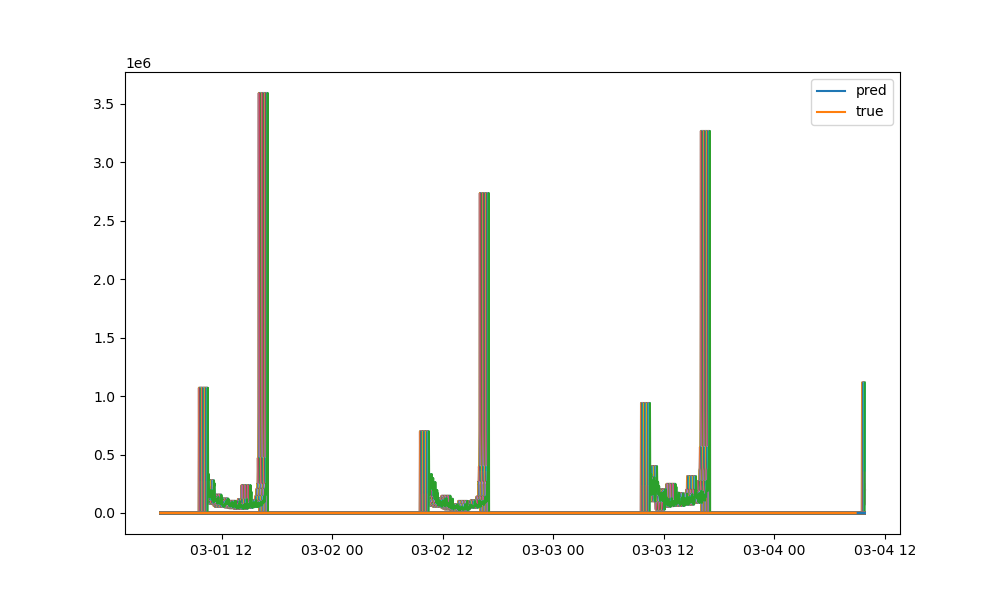

<function matplotlib.pyplot.show(block=None)>

In [61]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 6]

plt.plot(test_dates_list, y_hat_descaled)
plt.plot(test_dates_list, test_close_vals)
plt.legend(['pred','true'])
plt.show

In [ ]:
these_params = clfrbf.get_params()

In [ ]:
print(these_params)

In [ ]:
import pickle
# this methodology works for saving a trained model
pickle.dump(clfrbf, open("test.model", "wb"))

In [ ]:
import joblib as joblib
from joblib import dump
filename = "test.joblib"
joblib.dump(clfrbf, filename)

In [ ]:
import dill

with open("test", "wb") as dill_file:
    dill.dump(clfrbf, dill_file)

In [ ]:
this_save = dill.dumps(clfrbf) 

In [ ]:
this_load = pd.read_pickle(r'test.model')

In [ ]:
y_hat = this_load.predict(X_test)

In [ ]:
with open("test.model", "wb") as dill_file:
    dill.dump(this_save, dill_file)

In [ ]:
this_open = dill.load("test.model") 

In [ ]:
#with open("test.model", "rb") as dill_file:
    test_clf = dill.load(this_open)

In [ ]:
y_hat_descaled['adj_close']

In [130]:
y_hat_train.shape

(11784,)

In [131]:
pd.DataFrame(norms).shape

(11604, 1)

In [134]:
de_normed_y_hat = y_hat_train[slow+90:] * norms

<IPython.core.display.Javascript object>


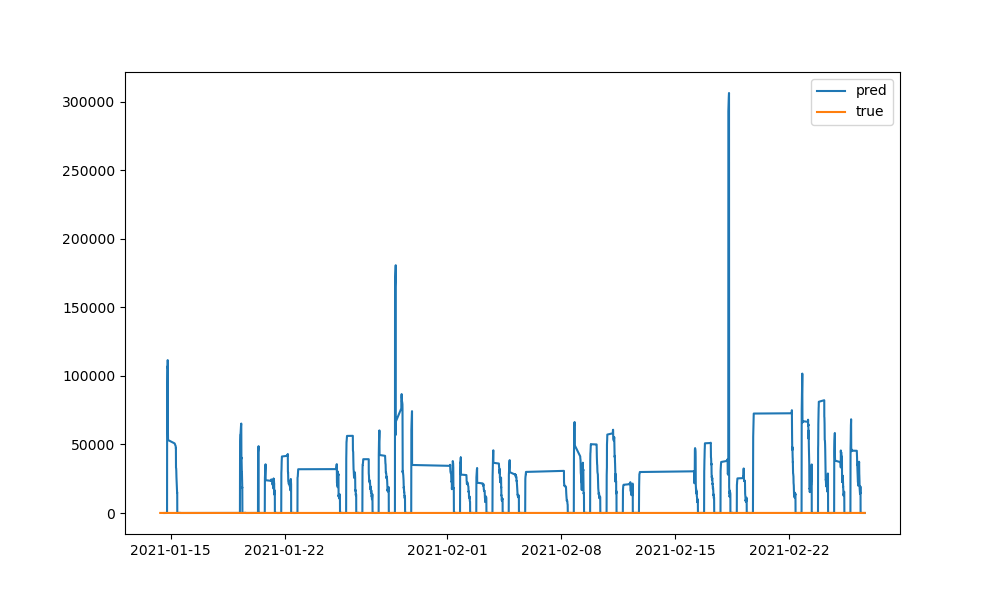

<function matplotlib.pyplot.show(block=None)>

In [139]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 6]

plt.plot(train_dates_list[slow+180:], de_normed_y_hat)
plt.plot(train_dates_list[slow:], train_close_vals[slow:])
plt.legend(['pred','true'])
plt.show